# Exploring Models With Synthetic Data
The advantage of synthetic data is that we know the prior or ground truth and we know exactly how concealed it is. That helps us to determine with certainty that an algorithm is per se capable of discovering the ground truth. If an algorithm fails on the easy task of learning from synthetic data, then it won't be good in real life. The opposite, unfortunately, is not true.

In [52]:
%matplotlib inline

import sys
import inspect

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column as fc
from tools import print_progress, array_in, create_input_data

from __future__ import division

## Generating Noisy Samples From A Well-Known Ground Truth

In [2]:
# create a function of x that returns random samples around a*x+b
def make_lin(a, b, rnd):
    def _f_a(x):
        mu = a*x + b
        return rnd(mu)
    return _f_a

---
Two linear but noisy signals:

In [3]:
f_a = make_lin(2, 1, lambda mu: np.random.normal(loc=mu, scale=1.0))
f_b = make_lin(-.5, -1.5, lambda mu: np.random.normal(loc=mu, scale=1.0))

---
A look at one of the signals:

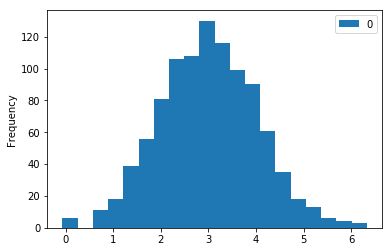

In [4]:
df = pd.DataFrame([f_a(1) for i in range(1000)])
df.plot.hist(bins=20);

---
Now we create a data set/frame representing $f_a(x)+f_b(y)$ as a random variable that depends on random variables $x$ and $y$

In [5]:
def create_data_frame_v1(size):
    x_data = np.random.uniform(high=5, low=-5, size=size)
    y_data = np.random.uniform(high=5, low=-5, size=size)
    f_data = f_a(x_data) + f_b(y_data)
    f_perf = -.5 * y_data - 1.5 + 2 * x_data + 1
    df = pd.DataFrame({'x': x_data, 'y': y_data, 'f': f_data, 'p': f_perf})
    return df

In total, this is equivalent to saying that the ground truth is:

$$ f(x, y) = 2x - \frac{1}{2} y - \frac{1}{2} $$


In [6]:
NUM_RECORDS = 10000

In [7]:
df_train = create_data_frame_v1(NUM_RECORDS)
df_train[:5]

,x,y,f,p
0,3.399682,-0.400144,9.614239,6.499435
1,-1.836593,1.228568,-5.998465,-4.787471
2,-4.130946,0.613711,-7.276137,-9.068748
3,1.340600,1.570992,-0.682609,1.395703
4,4.207173,2.263344,8.689191,6.782673


## Building A Linear Regressor From Scratch With Tensorflow
Let's train a self-made tensorflow linear regressor with the synthetic data to see whether it finds the coefficients above

In [8]:
try:
    sess.close()
except:
    print("OK. Was already closed or didn't exist. That's fine.")
    
sess = tf.InteractiveSession()

OK. Was already closed or didn't exist. That's fine.


The learning rate

In [9]:
lr = .01

---
### Creating The Tensorflow Graph

In [10]:
class Linear():
    def __init__(self, x_dim, lr):

        # Variables for the parameters: weights M and bias b
        self.M = tf.Variable(tf.zeros(shape=(1, x_dim)))
        self.b = tf.Variable(0.)

        # Placeholders for x and labels
        self.x = tf.placeholder(shape=(x_dim,None), dtype=tf.float32)
        self.lbls = tf.placeholder(shape=(1,None), dtype=tf.float32)

        # The prediction and the distance (loss)
        self.f = tf.matmul(self.M, self.x) + self.b
        self.d = tf.losses.mean_squared_error(self.lbls, self.f)

        # The gradients
        self.nM = tf.gradients(self.d, self.M)
        self.nb = tf.gradients(self.d, self.b)

        # The optimizers
        self.aM = tf.assign_add( self.M, tf.multiply(self.nM[0],-lr))
        self.ab = tf.assign_add( self.b, tf.multiply(self.nb[0], -lr))

        # The initializer
        self.init = tf.global_variables_initializer()
    
    def train(self, sess, x_data, labels_data, num_steps):        
        sess.run(self.init)
        for i in range(num_steps):
            _, dist, _, _, _, _ = sess.run([self.f, self.d, self.nM, self.nb, self.aM, self.ab], 
                                           feed_dict = {self.x: x_data, self.lbls: labels_data})
            print_progress("- Loss: {}", dist)
        return dist
    
    def predict(self, sess, x_data):
        pred = sess.run(self.f, feed_dict={self.x: x_data})
        return pred

---
### Perform The Training And Examine The Results

In [11]:
input_data = [list(df_train['x']), list(df_train['y'])]
lbls_data = [list(df_train['f'])]

In [12]:
linear1 = Linear(x_dim=2, lr=0.01)
linear1.train(sess, input_data, lbls_data, 1000)

- Loss: 2.0531539916992188

2.053154

We expect the parameters to be close to $2, -0.5, -0.5$:

In [13]:
sess.run([linear1.M, linear1.b])

[array([[ 2.001272  , -0.50020266]], dtype=float32), -0.5086103]

---
Now the tensor f represents the hypothesis. Let's evaluate it with some fresh test data

In [14]:
df_test = create_data_frame_v1(size=10000)
test_data = [list(df_test['x']), list(df_test['y'])]

In [15]:
predictions = linear1.predict(sess=sess, x_data=test_data)

In [16]:
df_test['predictions'] = predictions[0]
df_test[:10]

,x,y,f,p,predictions
0,4.421837,2.721789,7.242147,6.982780,6.979243
1,4.632382,-4.875022,11.584552,11.202274,11.200543
2,0.912983,2.531394,0.848731,0.060269,0.052307
3,-3.086742,-2.603373,-6.433733,-5.371798,-5.383807
4,-2.583154,-0.700489,-4.770781,-5.316064,-5.327818
5,-3.104859,-3.152265,-6.209662,-5.133586,-5.145506
6,-3.323252,4.547638,-13.472069,-9.420323,-9.434083
7,2.887259,1.600672,3.725684,4.474182,4.468920
8,2.785658,-4.228159,6.173240,7.185396,7.181186
9,-2.316506,-4.560759,-3.414165,-2.852632,-2.863264


We can see without surprise that the predictions are typically closer to the ground truth than to the noisy signal. This means we have enough data to average out the noise and reveal the ground truth. A look at the distribution of the errors reveals pure noise around 0. That's typically a good sign that our network has understood the data.

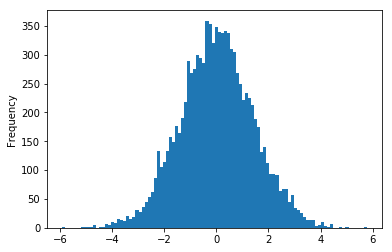

In [17]:
df_errors = df_test['f'] - df_test['predictions']
df_errors.plot.hist(bins=100);

## The Tensorflow LinearRegressor Estimator
Now we'll reproduce this with the high-level estimator API. Surprisingly, the calculations here take much longer than in the basic approach above

In [18]:
input_fn = tf.estimator.inputs.pandas_input_fn(df_train, shuffle=True, num_epochs=100, y=df_train['f'], batch_size=NUM_RECORDS)
feature_columns = [
    fc.numeric_column('x', dtype=tf.float32),
    fc.numeric_column('y', dtype=tf.float32)
]
config = tf.estimator.RunConfig(log_step_count_steps=5)

In [19]:
regressor = tf.estimator.LinearRegressor( feature_columns=feature_columns, config=config )

INFO:tensorflow:Using config: {'_model_dir': '/var/folders/cy/7hf1bx3113n2tbn4fvbjx0pc0000gn/T/tmp183sakuq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12b668780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


---
Perform the training on the regressor

In [20]:
regressor.train(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/cy/7hf1bx3113n2tbn4fvbjx0pc0000gn/T/tmp183sakuq/model.ckpt.
INFO:tensorflow:loss = 377856.8, step = 1
INFO:tensorflow:global_step/sec: 7.87774
INFO:tensorflow:loss = 183399.25, step = 6 (0.636 sec)
INFO:tensorflow:global_step/sec: 10.3908
INFO:tensorflow:loss = 123422.55, step = 11 (0.481 sec)
INFO:tensorflow:global_step/sec: 10.5092
INFO:tensorflow:loss = 89214.734, step = 16 (0.475 sec)
INFO:tensorflow:global_step/sec: 8.42879
INFO:tensorflow:loss = 67536.66, step = 21 (0.594 sec)
INFO:tensorflow:global_step/sec: 8.45852
INFO:tensorflow:loss = 53648.39, step = 26 (0.591 sec)
INFO:tensorflow:global_step/sec: 8.44646
INFO:tensorflow:loss = 44181.844, step = 31 (0.592 sec)
INFO:tensorflow:global_

---
### Comparing The Results

In [21]:
input_fn_test = tf.estimator.inputs.pandas_input_fn(df_test, shuffle=False)

In [22]:
generator = regressor.predict(input_fn_test)

In [23]:
pred_estimator = [f['predictions'][0] for f in generator]
df_test['pred_estimator'] = pred_estimator
df_test[:10]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/cy/7hf1bx3113n2tbn4fvbjx0pc0000gn/T/tmp183sakuq/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


,x,y,f,p,predictions,pred_estimator
0,4.421837,2.721789,7.242147,6.982780,6.979243,6.737907
1,4.632382,-4.875022,11.584552,11.202274,11.200543,10.947616
2,0.912983,2.531394,0.848731,0.060269,0.052307,0.003874
3,-3.086742,-2.603373,-6.433733,-5.371798,-5.383807,-5.212363
4,-2.583154,-0.700489,-4.770781,-5.316064,-5.327818,-5.184055
5,-3.104859,-3.152265,-6.209662,-5.133586,-5.145506,-4.973069
6,-3.323252,4.547638,-13.472069,-9.420323,-9.434083,-9.249619
7,2.887259,1.600672,3.725684,4.474182,4.468920,4.311946
8,2.785658,-4.228159,6.173240,7.185396,7.181186,7.029784
9,-2.316506,-4.560759,-3.414165,-2.852632,-2.863264,-2.734170


We see that the pre-canned estimator arrives at (almost) the same results as our hand-made linear regressor. Not that we had a doubt, though...

---
## Learning From Categorical Data

Let's now assume that the ground truth is a totally unexpected function of the week day and time of day. That could happen e.g., if you measure the humidity and fail to realize that your sensor is near a dry-cleaner's. Let's assume the dry-cleaner's have peek hours on Mon, Tue, Wed from 18:00h to 21:00 and Fri, Sat from 14:00h to 16:00h. During those hours humidity is significantly higher due to the steam produced there. 

First, let's create a dataset that reflects that situation. Day of week and hour of day shall be represented by categorical data. 

### Creating a new dataframe with days of week and hour-of-day columns

In [24]:
NUM_RECORDS = 20000

In [25]:
# create a function of x that returns random samples around a constant, if the hour of week 
conditions = np.array([
    (0, 18), (0, 19), (0, 20), (0, 21), # Mondays
    (1, 18), (1, 19), (1, 20), (1, 21), # Tuesdays
    (2, 18), (2, 19), (2, 20), (2, 21), # Wednesdays
    # closed on Thursdays
    (4, 14), (4, 15), (4, 16),          # Fridays
    (5, 14), (5, 15), (5, 16)           # Saturdays
    # closed on Sundays
    ])

def make_noisy_amplitude_function(amplitude):
    def _f(c1, c2):
        zipped = zip(c1,c2)
        res = array_in(zipped, conditions)        
        return res * (np.random.normal( 0 * res, .2 ) + amplitude)
    return _f

In [26]:
def create_data_frame_v2(size, amplitude=5.0):
    x_data = np.random.uniform(high=5, low=-5, size=size)
    y_data = np.random.uniform(high=5, low=-5, size=size)
    dow_data = np.random.randint(7, size=size)
    hod_data = np.random.randint(24, size=size)
    f_data = f_a(x_data) + f_b(y_data)
    
    f_special = make_noisy_amplitude_function(amplitude)(dow_data, hod_data)

    f_total = f_data + f_special
    f_perf = -.5 * y_data - 1.5 + 2 * x_data + 1
    df = pd.DataFrame({'x': x_data, 'y': y_data, 'dow': dow_data, 'hod': hod_data, 'f_orig': f_data, 'p': f_perf, 'special': f_special, 'f': f_total})
    return df

In [27]:
df_train_v2 = create_data_frame_v2(size = NUM_RECORDS, amplitude=10.0)
df_train_v2[:20]

,x,y,dow,hod,f_orig,p,special,f
0,0.434463,2.611624,0,14,-0.723552,-0.936887,0.000000,-0.723552
1,-0.515673,1.674799,0,12,-3.378942,-2.368745,0.000000,-3.378942
2,-3.762068,-0.257951,3,20,-6.573010,-7.895161,0.000000,-6.573010
3,-2.293598,0.114673,1,13,-7.986032,-5.144533,0.000000,-7.986032
4,-3.942051,1.991502,0,12,-6.574093,-9.379854,0.000000,-6.574093
5,1.647159,0.453196,6,5,0.781300,2.567720,0.000000,0.781300
6,-4.729679,-4.162701,6,17,-9.673458,-7.878008,0.000000,-9.673458
7,-2.388270,4.353431,0,15,-5.276994,-7.453255,0.000000,-5.276994
8,2.936654,1.052962,5,9,4.992209,4.846827,0.000000,4.992209
9,0.657399,1.929293,1,7,1.013177,-0.149848,0.000000,1.013177


---
### Create a data set suitable for training
In the following, our assumption that it is particular hours on particular days makes this problem a candidate for the categorical features 'hour of day' and 'day of week'. Hence, in a first step, let's take those two features into account. For that, we have to one-hot encode those features.

In [28]:
ordinals = list(df_train_v2['dow'])
one_hot_dows = np.transpose(np.eye(7)[ordinals])
one_hot_dows[:7,:10]

array([[1., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]])

In [29]:
ordinals = list(df_train_v2['hod'])
one_hot_hods = np.transpose(np.eye(24)[ordinals])

In [30]:
input_numerical = [list(df_train_v2['x']), list(df_train_v2['y'])]
lbls_data = [list(df_train_v2['f'])]
input_data = np.append(input_numerical, one_hot_dows, axis=0)
input_data = np.append(input_data, one_hot_hods, axis=0)
print("shapes: {} + {} + {} = {}".format(np.shape(input_numerical), np.shape(one_hot_dows), np.shape(one_hot_hods), np.shape(input_data)))

shapes: (2, 20000) + (7, 20000) + (24, 20000) = (33, 20000)


Now we have 33 columns, 31 of which only sparsely populated. That's ok for the time being.

In [31]:
input_data[:,:4]

array([[ 0.43446255, -0.51567307, -3.7620684 , -2.29359801],
       [ 2.61162374,  1.6747987 , -0.25795063,  0.11467317],
       [ 1.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.

---
Hereafter, we'll use create_input_data from the tools file to achieve just that.

In [32]:
import inspect

In [33]:
print(inspect.getsource(create_input_data))

def create_input_data(df, select_feats=[], oh_feats={}, cross_feats=[]):    
    """
    create a list of input columns from pandas raw data
    df: a pandas dataframe containing raw input data
    select_feats: an array containing the names of features to be selected without transformation
    oh_feats: a dictionary containing the names and sizes of discrete numerical features that are to be one-hot encoded
    cross_feats: a list of oh_feats consisting of two discrete features to cross
    """

    def _safe_append(l, r):
        if l == [] or l is None:
            return r
        else:
            return np.append(l, r, axis=0)

    res = [list(df[n]) for n in select_feats]
    
    for k in oh_feats:
        res = _safe_append(res, one_hot(df[k], oh_feats[k]))

    for c in cross_feats:
        keys = list(c.keys())
        keys.sort()
        
        lk, ls = keys[0], c[keys[0]]
        rk, rs = keys[1], c[keys[1]]
        lhs = one_hot(df[lk], ls)
        rhs = one_hot(df[rk],

---
### Create the network and start the training

We use once more our self-made linear regressor. Below is the code that we hade previously, only this time augmented by the 24 + 7 new input features from the categorical columns. Observe that we train a long time with a lot more data, and the training loss still doesn't improve much.

In [34]:
NUMERICAL_DIM = 2 # namely x and y
WEEKDAY_DIM = 7 # obviously
HOUR_OF_DAY_DIM = 24
X_DIM = NUMERICAL_DIM + WEEKDAY_DIM + HOUR_OF_DAY_DIM

In [35]:
linear2 = Linear(X_DIM, .01)
linear2.train(sess, input_data, lbls_data, 5000)

- Loss: 8.156059265136719

8.156059

That loss is significantly larger than the one that we experienced in the simple case. So either the signal/noise ratio is worse (we know it isn't) or there's some signal in the data that we don't recognize yet. 

---
Sometimes the distribution of the prediction errors reveals additional facts of the problems that our network has. Usually we'll need large enough samples to allow for sufficient statistics.

In [36]:
df_test_v2 = create_data_frame_v2(size = 20000, amplitude=10)
test_data = create_input_data(df=df_test_v2, select_feats=['x','y'], oh_feats={'dow': 7, 'hod': 24})

pred = linear2.predict(x_data=test_data, sess=sess)
df_test_v2['predicted'] = pred[0]
df_test_v2[['f', 'p', 'predicted', 'special']][:10]

,f,p,predicted,special
0,-4.825540,-4.442504,-3.782084,0.000000
1,-6.329561,-9.379998,-9.279288,0.000000
2,-10.774609,-10.276996,-9.495276,0.000000
3,-2.276895,-1.121980,-0.968489,0.000000
4,5.294388,6.978662,5.994357,0.000000
5,-7.229097,-8.510607,-8.382927,0.000000
6,12.506073,4.695551,9.622369,9.999974
7,5.755718,6.656700,7.401284,0.000000
8,-7.178016,-5.693405,-1.123306,0.000000
9,-4.965578,-6.644349,-6.017790,0.000000


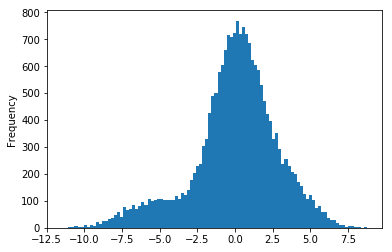

In [37]:
df_errors = df_test_v2['predicted'] - df_test_v2['f']
df_errors.plot.hist(bins=100);

We can see from the error distribution that there's some really interesting stuff going on. This is almost certainly a hint that our data contains structure that we didn't discover yet. This distribution is telling: For the majority of the data - the large bump - we have a tendency to over-predict. For some minority though we significantly under-predict. This is a typical sign that the linear regression is finding a weak compromise between two distinct and somehow unrelated distributions that make up our total input data.

Obviously, although or network actually had all the information it needed, simply adding the categorical features didn't allow it to learn the specific characteristic, namely the "and" relationship like in: "The humidity is higher, when it's Wednesday *and* it's 18:00h". 

Feature crossings and embeddings to the rescue!

## Feature Crossings

Let's look at an example: This is Wednesday, 08:00h:

In [38]:
wednesday = np.array([[0,0,1,0,0,0,0]])
at_0800 = np.zeros((1,24))
at_0800[0,8] = 1
wednesday, at_0800

(array([[0, 0, 1, 0, 0, 0, 0]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]]))

Crossing categorical features $a$ and $b$ means: Put a 1 only where both $a$ and $b$ have a one. Put zeros anywhere else. Python broadcasting helps us achieve that with ease.

In [39]:
wednesday_at_0800 = wednesday.T * at_0800
wednesday_at_0800

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [40]:
cross = np.reshape(wednesday_at_0800, newshape=(1,-1))
np.argmax(cross) == 2 * 24 + 8 # Wed * 24 + at_0800

True

It gets a little more involved when dealing with a batch of feature pairs as you can see in the example below:

In [41]:
dows = np.array([[0,0,1,0,0,0,0],[0,0,0,0,0,1,0]])
hods = np.zeros((2,24))
hods[0,8] = 1
hods[1,16] = 1
dows, hods

(array([[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0.]]))

In [42]:
[(dows[i].reshape(7,1) * hods[i].reshape(1,24)).reshape(168) for i in range(2)]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

---
Now, instead of feeding both features independently we feed the feature cross into our linear regression model. Note that we need a lot of data to have sufficient statistics for each hour of the week

In [43]:
NUM_RECORDS = 20000

df_train_v3 = create_data_frame_v2(size = NUM_RECORDS, amplitude=10.0)
input_data_v3 = create_input_data(df=df_train_v3, select_feats=['x', 'y'], cross_feats=[{'dow': 7, 'hod': 24}])    
lbls_data_v3 = [list(df_train_v3['f'])]
input_data_v3.shape, len(lbls_data_v3[0])

((170, 20000), 20000)

In [44]:
regressor_v3 = Linear(lr=.05, x_dim=170)
regressor_v3.train(sess=sess, num_steps=4000, x_data=input_data_v3, labels_data=lbls_data_v3)

- Loss: 2.077442169189453

2.0774422

---
We can see that the loss function has indeed gone down dramatically. Now let's examine the error statistics on some fresh data.

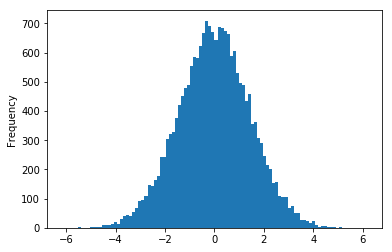

In [45]:
df_test_v3 = create_data_frame_v2(size = 20000, amplitude=10.0)
input_data_test_v3 = create_input_data(df=df_test_v3, select_feats=['x', 'y'], cross_feats=[{'dow': 7, 'hod': 24}])    
preds = regressor_v3.predict(sess=sess, x_data=input_data_test_v3)

errors = preds[0] - df_test_v3['f']
df_test_v3['preds'] = preds[0]
df_test_v3['err'] = errors
df_test_v3['err'].plot.hist(bins=100);

Still, there's some subtle asymmetry in the error distribution, depending on how long you trained, but we can see that the characteristic second bump has disappeared. When we look at the weights associated with the 168 different hours of a week, we spot a few larger positive values amongst otherwise smaller negative values.

In [46]:
weights = regressor_v3.M.eval()
weights_t = weights.squeeze()[2:]
weights_t

array([-0.92451054, -0.9105595 , -0.7312683 , -0.99688226, -0.82971704,
       -0.9796364 , -1.0322107 , -0.7919396 , -0.9527571 , -0.83081305,
       -0.8958984 , -1.1073065 , -0.8674313 , -1.0217636 , -0.8798526 ,
       -1.0595101 , -0.9710994 , -0.9295249 ,  8.123133  ,  8.147578  ,
        8.058648  ,  7.983456  , -1.0556803 , -1.027305  , -0.9248636 ,
       -0.9859836 , -0.82457083, -0.8321773 , -1.0499196 , -0.87207127,
       -0.947699  , -0.86126167, -0.95848054, -0.9792089 , -1.045009  ,
       -1.064327  , -0.93257385, -0.99947834, -1.1326177 , -0.9904683 ,
       -0.7458987 , -1.0242755 ,  7.9645324 ,  8.168488  ,  7.723741  ,
        8.146595  , -1.1398586 , -1.1344804 , -0.98596895, -1.0821922 ,
       -0.71281946, -1.1208999 , -1.0399061 , -0.9765209 , -0.8167832 ,
       -1.0876834 , -0.7790154 , -0.9157768 , -1.1180328 , -1.0416971 ,
       -0.8730049 , -1.0084373 , -1.1433038 , -1.0723602 , -1.0801103 ,
       -0.93582433,  8.107384  ,  8.155861  ,  8.008792  ,  7.75

The indexes of the larger values allow us to discover exactly those hours of week during which the dry-cleaner anomalies are observed. The network truly learned when these anomalies are typically observed and adds some more humidity in its prediction during those times of the week. Ain't that cool?

In [48]:
indexes = [i for i in range(168) if weights_t[i] > 1]
how_detected = [(i / 24, i % 24 ) for i in indexes]
how_detected = sorted(how_detected, key=lambda d: d[0])
list(zip(how_detected, conditions))

[((0.75, 18), array([ 0, 18])),
 ((0.7916666666666666, 19), array([ 0, 19])),
 ((0.8333333333333334, 20), array([ 0, 20])),
 ((0.875, 21), array([ 0, 21])),
 ((1.75, 18), array([ 1, 18])),
 ((1.7916666666666667, 19), array([ 1, 19])),
 ((1.8333333333333333, 20), array([ 1, 20])),
 ((1.875, 21), array([ 1, 21])),
 ((2.75, 18), array([ 2, 18])),
 ((2.7916666666666665, 19), array([ 2, 19])),
 ((2.8333333333333335, 20), array([ 2, 20])),
 ((2.875, 21), array([ 2, 21])),
 ((4.583333333333333, 14), array([ 4, 14])),
 ((4.625, 15), array([ 4, 15])),
 ((4.666666666666667, 16), array([ 4, 16])),
 ((5.583333333333333, 14), array([ 5, 14])),
 ((5.625, 15), array([ 5, 15])),
 ((5.666666666666667, 16), array([ 5, 16]))]

To the left, the hours of the week as detected by the network, to the left the conditions that lead to the anomalies in the data. A perfect fit!

In [49]:
indexes

[18, 19, 20, 21, 42, 43, 44, 45, 66, 67, 68, 69, 110, 111, 112, 134, 135, 136]

In [53]:
[(i // 24, i % 24 ) for i in indexes]

[(0.75, 18),
 (0.7916666666666666, 19),
 (0.8333333333333334, 20),
 (0.875, 21),
 (1.75, 18),
 (1.7916666666666667, 19),
 (1.8333333333333333, 20),
 (1.875, 21),
 (2.75, 18),
 (2.7916666666666665, 19),
 (2.8333333333333335, 20),
 (2.875, 21),
 (4.583333333333333, 14),
 (4.625, 15),
 (4.666666666666667, 16),
 (5.583333333333333, 14),
 (5.625, 15),
 (5.666666666666667, 16)]